In [46]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from pyEulerCurves import difference_ECC
from pyEulerCurves import ECC_from_pointcloud, plot_euler_curve
import time

In [5]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

In [125]:
def exact_ecc_alpha(pointcloud):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    simplices = list(st.get_filtration())
    
    contribs = []
    
    for s in simplices:
        if len(contribs)>0 and s[1] == contribs[-1][0]:
            contribs[-1][1] = contribs[-1][1] + (-1)**(len(s[0])-1)
        else:
            contribs.append([s[1], (-1)**(len(s[0])-1)])       
        
    contribs = [c for c in contribs if c[1]!=0]#to_drop = [c[1] == 0 for c in contribs]
    return contribs

In [123]:
def exact_ecc_distance(ECC1, ECC2):
    filtration_steps = list(set(([f[0] for f in ECC1] + [f[0] for f in ECC2] )))
    filtration_steps.sort()

    total_difference = 0
    
    current1val = ECC1[0][1]
    current2val = ECC2[0][1]
    current_difference = np.abs(current1val - current2val)
    i1 = 1
    i2 = 1
    
    
    for i in range(1,len(filtration_steps)):
        total_difference = total_difference + current_difference*(filtration_steps[i]-filtration_steps[i-1])
        if i1<len(ECC1) and ECC1[i1][0] == filtration_steps[i] and i2<len(ECC2) and ECC2[i2][0] == filtration_steps[i]:
            current1val = current1val + ECC1[i1][1]
            current2val = current2val + ECC2[i2][1]
            i1 = i1+1
            i2 = i2+1
        elif i1<len(ECC1) and ECC1[i1][0] == filtration_steps[i]:#but not ECC2
            current1val = current1val + ECC1[i1][1]
            i1 = i1 +1 
        elif i2<len(ECC2) and ECC2[i2][0] == filtration_steps[i]:#but not ECC1
            current2val = current2val + ECC2[i2][1]
            i2 = i2+1
        
        current_difference = np.abs(current1val - current2val)
        
    
    return total_difference

In [170]:
RV = st.norm()
sample = RV.rvs((20,2))
sample2 = RV.rvs((20,2))
sample

array([[ 4.99440834e-01, -1.31681925e+00],
       [ 2.01829227e+00, -2.00784511e+00],
       [ 5.49165332e-01,  5.63357498e-01],
       [-6.65216796e-01, -1.02795500e+00],
       [ 1.14357310e+00,  3.73082024e-01],
       [ 5.06328616e-01, -6.09819223e-01],
       [ 5.09564848e-01,  7.90208562e-01],
       [ 1.26287507e-01, -2.32460396e-01],
       [-1.64551511e+00, -1.13565529e-01],
       [-1.78847421e+00, -1.24412719e-01],
       [ 1.65488664e+00, -1.38423860e+00],
       [ 2.02702732e+00, -2.45729405e-01],
       [-5.37971036e-01, -1.02495379e+00],
       [ 5.29748594e-02,  9.40422208e-02],
       [ 9.86851417e-01, -4.94169632e-01],
       [-1.73748117e+00, -3.60787120e-01],
       [ 2.08260507e+00,  1.09479785e+00],
       [-3.27335073e-04,  1.98400842e-01],
       [ 1.74472457e+00,  4.51917699e-01],
       [ 5.39507711e-01,  1.85163094e-01]])

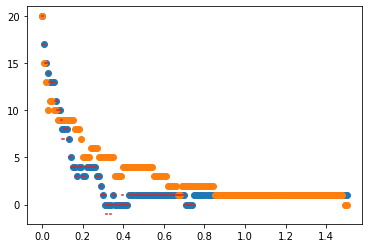

In [173]:

f,ax = plt.subplots()
ec = sampled_ecc_alpha(sample, 151,1.5)
ec2 = sampled_ecc_alpha(sample2, 151,1.5)
contribs = exact_ecc_alpha(sample)
contribs2 = exact_ecc_alpha(sample2)
ax.scatter(np.linspace(0,1.5,151), ec)
ax.scatter(np.linspace(0,1.5,151), ec2)
c0 = contribs[0][1]
for i in range(1,len(contribs)):
    ax.plot((contribs[i-1][0],contribs[i][0]),(c0,c0), c="tab:red")
    c0 = c0 + contribs[i][1]

plt.show()

In [179]:
iterations = 1000
exact_times = np.zeros(iterations)
approx_times = np.zeros(iterations)

for i in range(0,iterations):
    tic = time.time()
    exact = exact_ecc_distance(contribs, contribs2)
    exact_times[i] = time.time()-tic
    tic = time.time()
    approx = np.linalg.norm(ec-ec2, ord=1)/100
    approx_times[i] = time.time()-tic
    
print("exact", np.median(exact_times))
print("approx", np.median(approx_times))
print(np.median(exact_times)/np.median(approx_times))

exact 0.0002815723419189453
approx 9.298324584960938e-06
30.28205128205128
